In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import html
from sklearn.model_selection import train_test_split
import pandas as pd, numpy as np, re, joblib, nltk, matplotlib.pyplot as plt, seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
nltk.download('vader_lexicon')

plt.rcParams['font.family'] = 'DejaVu Sans'
# Nicer default plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

#  full columns display
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gurpr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
DATA_PATH = "../data/twitter_disaster.csv"  
df = pd.read_csv(DATA_PATH)

print(f"Dataset shape : {df.shape}")
df.head()


Dataset shape : (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [21]:
df.info()

#  summary statistics for numeric columns
df.describe(include=[np.number])

# Count missing values per column
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# Class Distribution (Disaster vs Non‑disaster)

In [23]:


# Numeric ratio
class_counts = df['target'].value_counts(normalize=True)*100
print(class_counts.rename("percentage (%)"))


target
0    57.034021
1    42.965979
Name: percentage (%), dtype: float64


# Keyword Frequency Analysis

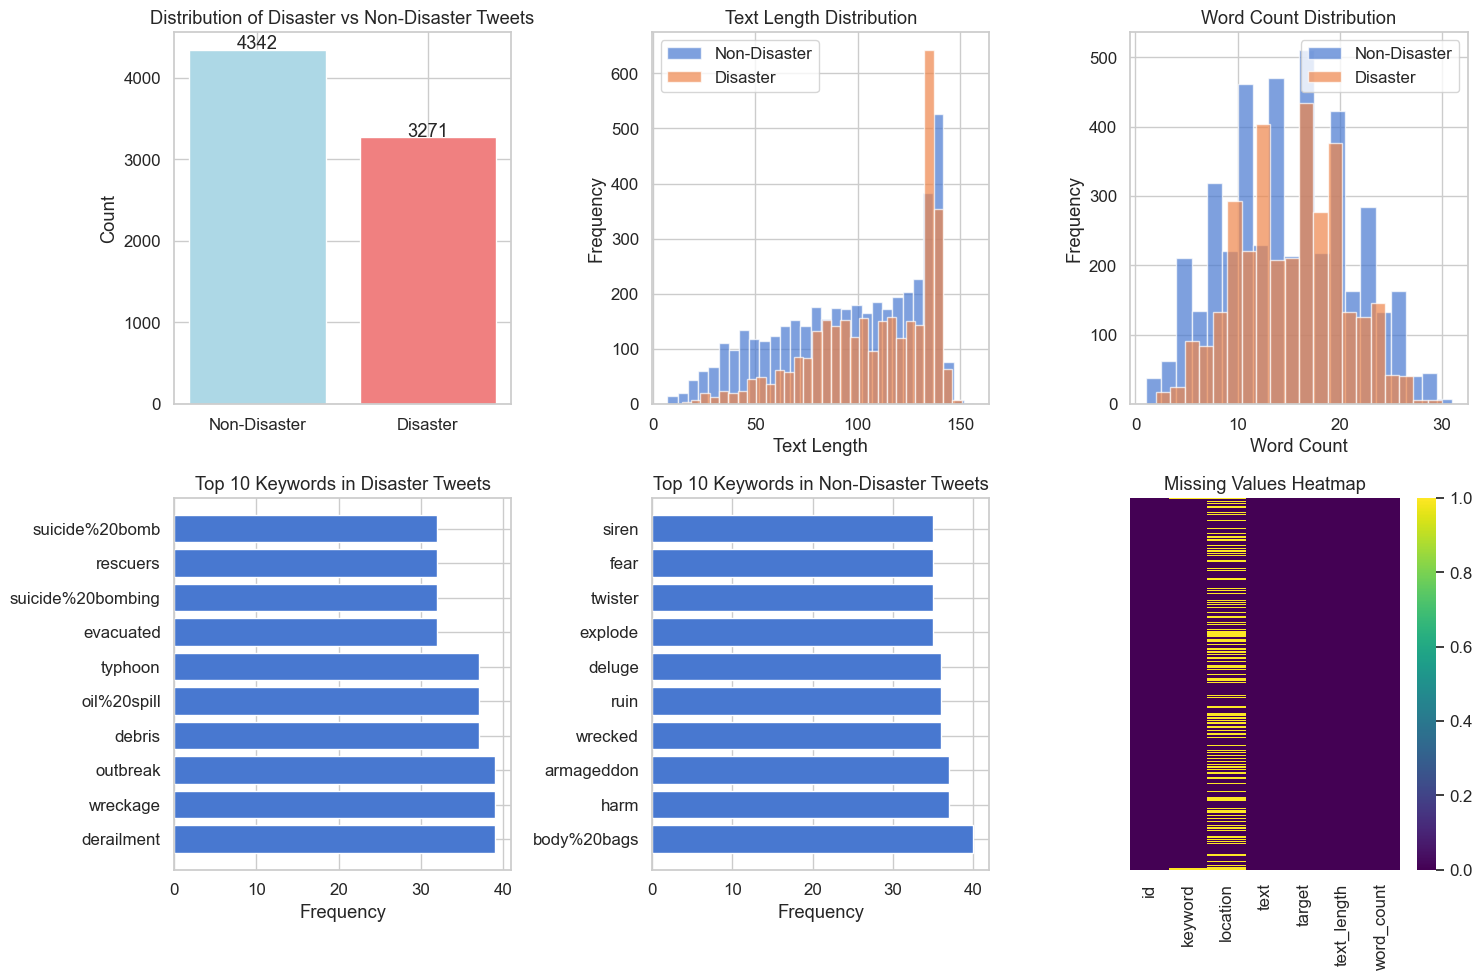

In [25]:
# Data Exploration - Visualizations
plt.figure(figsize=(15, 10))

# 1. Target distribution
plt.subplot(2, 3, 1)
target_counts = df['target'].value_counts()
plt.bar(['Non-Disaster', 'Disaster'], target_counts.values, color=['lightblue', 'lightcoral'])
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.ylabel('Count')
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 10, str(v), ha='center')

# 2. Text length distribution
plt.subplot(2, 3, 2)
df['text_length'] = df['text'].str.len()
plt.hist(df[df['target']==0]['text_length'], alpha=0.7, label='Non-Disaster', bins=30)
plt.hist(df[df['target']==1]['text_length'], alpha=0.7, label='Disaster', bins=30)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()

# 3. Word count distribution
plt.subplot(2, 3, 3)
df['word_count'] = df['text'].str.split().str.len()
plt.hist(df[df['target']==0]['word_count'], alpha=0.7, label='Non-Disaster', bins=20)
plt.hist(df[df['target']==1]['word_count'], alpha=0.7, label='Disaster', bins=20)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

# 4. Top keywords for disaster tweets
plt.subplot(2, 3, 4)
disaster_keywords = df[df['target']==1]['keyword'].value_counts().head(10)
plt.barh(disaster_keywords.index, disaster_keywords.values)
plt.title('Top 10 Keywords in Disaster Tweets')
plt.xlabel('Frequency')

# 5. Top keywords for non-disaster tweets
plt.subplot(2, 3, 5)
non_disaster_keywords = df[df['target']==0]['keyword'].value_counts().head(10)
plt.barh(non_disaster_keywords.index, non_disaster_keywords.values)
plt.title('Top 10 Keywords in Non-Disaster Tweets')
plt.xlabel('Frequency')

# 6. Missing values heatmap
plt.subplot(2, 3, 6)
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')

plt.tight_layout()
plt.show()


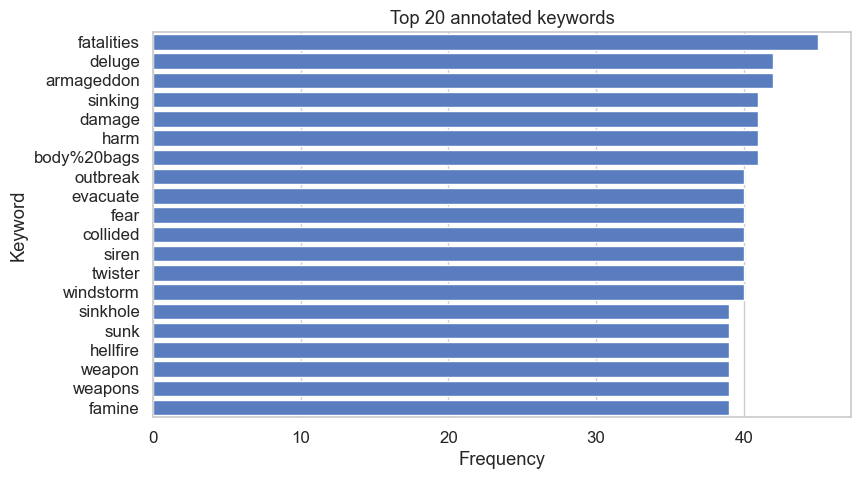

In [27]:
top_kw = (
    df['keyword']
    .dropna()
    .str.lower()
    .value_counts()
    .head(20)
)

plt.figure(figsize=(9,5))
sns.barplot(x=top_kw.values, y=top_kw.index, orient='h')
plt.title("Top 20 annotated keywords")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.show()


# Token‑level frequency inside disaster tweets only

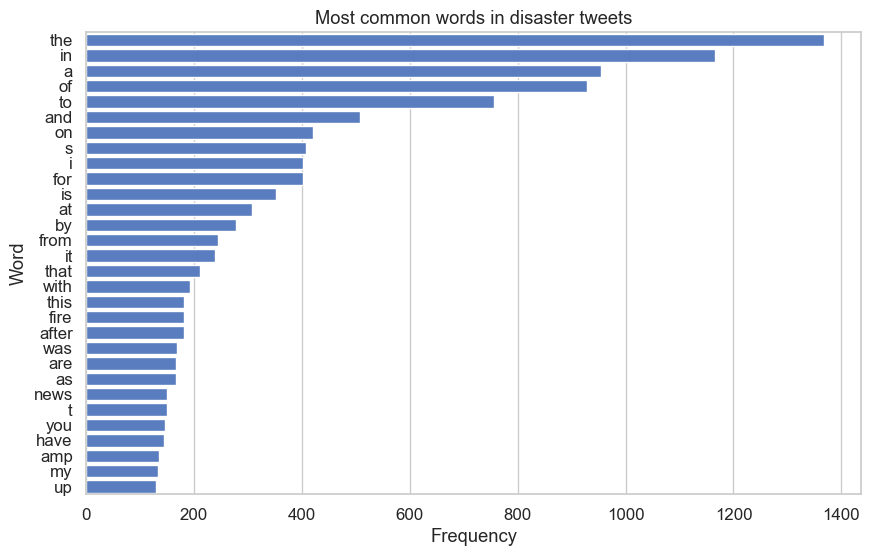

In [29]:

def simple_clean(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)      # links
    text = re.sub(r'[^a-z\s]', ' ', text)                  # keep letters/spaces
    return text

disaster_text = " ".join(df[df['target']==1]['text'].apply(simple_clean))
tokens = disaster_text.split()

# Count tokens
token_counts = Counter(tokens)
common_tokens = token_counts.most_common(30)

# Convert to DataFrame for a barplot
tok_df = pd.DataFrame(common_tokens, columns=['token','freq'])

plt.figure(figsize=(10,6))
sns.barplot(x='freq', y='token', data=tok_df, orient='h')
plt.title("Most common words in disaster tweets")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()


# WordCloud

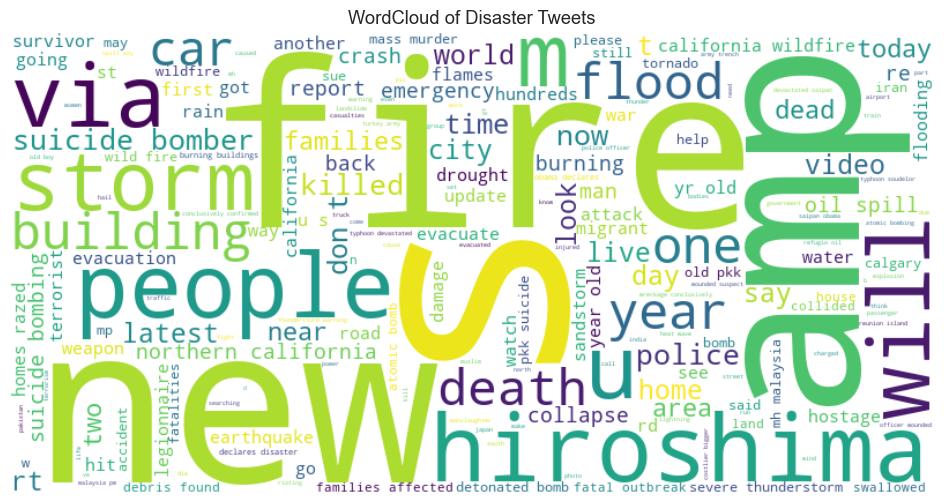

In [31]:
wc = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Disaster Tweets")
plt.show()


In [33]:


def clean_tweet(text: str) -> str:
    """
    Minimal yet effective cleaning for tweet text.
    1. Unescape HTML.
    2. Lower‑case.
    3. Remove URLs & mentions.
    4. Strip hashtags (#) but keep the word.
    5. Remove everything that is not a letter or space.
    6. Remove multiple spaces.
    """
    if pd.isna(text):
        return ""
    
    text = html.unescape(text)                 
    text = text.lower()
    
    # URLs
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    # Mentions
    text = re.sub(r"@\w+", " ", text)
    # Hashtag sign
    text = re.sub(r"#", " ", text)
    # Keep letters a‑z
    text = re.sub(r"[^a-z\s]", " ", text)
    # Collapse whitespace
    text = re.sub(r"\s{2,}", " ", text).strip()
    
    return text


In [35]:
# Handle missing values
df['keyword'] = df['keyword'].fillna('')
df['location'] = df['location'].fillna('')

In [37]:
df = df.copy()
df["clean_text"] = df["text"].apply(clean_tweet)

df[["text", "clean_text"]].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,our deeds are the reason of this earthquake may allah forgive us all
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California",people receive wildfires evacuation orders in california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,just got sent this photo from ruby alaska as smoke from wildfires pours into a school


# Tokenisation

In [39]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gurpr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gurpr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gurpr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [43]:

def tokenize(text: str) -> list[str]:
    """Return a list of lemmatised tokens without stop‑words."""
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in stop_words and len(tok) > 2      # drop stop‑words & 1‑2 char tokens
    ]
    return tokens

# Make a new column with tokens 
df["tokens"] = df["clean_text"].apply(tokenize)

df[["clean_text", "tokens"]].head()

,clean_text,tokens
0,our deeds are the reason of this earthquake may allah forgive us all,"[deed, reason, earthquake, may, allah, forgive]"
1,forest fire near la ronge sask canada,"[forest, fire, near, ronge, sask, canada]"
2,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,"[resident, asked, shelter, place, notified, officer, evacuation, shelter, place, order, expected]"
3,people receive wildfires evacuation orders in california,"[people, receive, wildfire, evacuation, order, california]"
4,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,"[got, sent, photo, ruby, alaska, smoke, wildfire, pours, school]"


#  Label Encoding

In [45]:
df["target"] = df["target"].astype(int)
df["target"].value_counts()


target
0    4342
1    3271
Name: count, dtype: int64

# Train‑Test Split

In [47]:


X_text = df["clean_text"].values          # numpy array of cleaned strings
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print(f"Train size : {len(X_train)}, Test size : {len(X_test)}")


Train size : 6090, Test size : 1523


In [49]:
# Save processed data
df.to_csv('../data/processed_disaster_tweets.csv', index=False)
print("\nProcessed data saved to 'processed_disaster_tweets.csv'")


Processed data saved to 'processed_disaster_tweets.csv'


In [57]:
DATA_PATH = "../data/processed_disaster_tweets.csv"  
df = pd.read_csv(DATA_PATH)

print(f"Dataset shape : {df.shape}")
df.head(10)

Dataset shape : (7613, 9)


,id,keyword,location,text,target,text_length,word_count,clean_text,tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,13,our deeds are the reason of this earthquake may allah forgive us all,"['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive']"
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,forest fire near la ronge sask canada,"['forest', 'fire', 'near', 'ronge', 'sask', 'canada']"
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,22,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,"['resident', 'asked', 'shelter', 'place', 'notified', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expected']"
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65,8,people receive wildfires evacuation orders in california,"['people', 'receive', 'wildfire', 'evacuation', 'order', 'california']"
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,16,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,"['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfire', 'pours', 'school']"
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1,110,18,rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires,"['rockyfire', 'update', 'california', 'hwy', 'closed', 'direction', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfire']"
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1,95,14,flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas,"['flood', 'disaster', 'heavy', 'rain', 'cause', 'flash', 'flooding', 'street', 'manitou', 'colorado', 'spring', 'area']"
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1,59,15,i m on top of the hill and i can see a fire in the woods,"['top', 'hill', 'see', 'fire', 'wood']"
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1,79,12,there s an emergency evacuation happening now in the building across the street,"['emergency', 'evacuation', 'happening', 'building', 'across', 'street']"
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1,52,10,i m afraid that the tornado is coming to our area,"['afraid', 'tornado', 'coming', 'area']"


# Add Sentiment Analysis Features

In [60]:
sia = SentimentIntensityAnalyzer()
sent = df['clean_text'].apply(lambda t: pd.Series(sia.polarity_scores(t)))
df = pd.concat([df, sent], axis=1)


# Add Metadata Features

In [63]:
# Tweet Length
df['char_count'] = df['text'].apply(len)

# Word count
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Hashtag count
df['hashtag_count'] = df['text'].apply(lambda x: len(re.findall(r"#\w+", x)))

# Mention count
df['mention_count'] = df['text'].apply(lambda x: len(re.findall(r"@\w+", x)))

df[['char_count', 'word_count', 'hashtag_count', 'mention_count']].head()


,char_count,word_count,hashtag_count,mention_count
0,69,13,1,0
1,38,7,0,0
2,133,22,0,0
3,65,7,1,0
4,88,16,2,0


# TF-IDF Vectorization of Text

In [69]:
X_text = df['clean_text']
y = df['target']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42)

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Combine Text Features + Metadata + Sentiment

In [72]:
# Additional features
feature_cols = ['char_count', 'word_count', 'hashtag_count', 'mention_count',
                'neg', 'neu', 'pos', 'compound']

X_additional = df[feature_cols]
X_train_add, X_test_add = train_test_split(X_additional, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_add_scaled = scaler.fit_transform(X_train_add)
X_test_add_scaled = scaler.transform(X_test_add)

# Combine TF-IDF + other features
from scipy.sparse import hstack
X_train_final = hstack((X_train_tfidf, X_train_add_scaled))
X_test_final = hstack((X_test_tfidf, X_test_add_scaled))

# MODEL SELECTION & TRAINING

In [75]:
#Logistic Regression
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train_final, y_train)

y_pred_lr = log_reg.predict(X_test_final)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       874
           1       0.81      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



# Random Forest Classifier

In [78]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_final.toarray(), y_train)

y_pred_rf = rf.predict(X_test_final.toarray())
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       874
           1       0.85      0.62      0.72       649

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.77      1523
weighted avg       0.80      0.79      0.78      1523



# Neural Network (MLPClassifier from Scikit-learn)

In [81]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=300)
mlp.fit(X_train_final, y_train)

y_pred_mlp = mlp.predict(X_test_final)
print("MLP Classifier Report:")
print(classification_report(y_test, y_pred_mlp))

MLP Classifier Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       874
           1       0.74      0.71      0.73       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



# Cross Validation

In [84]:

cv_scores = cross_val_score(log_reg, X_train_final, y_train, cv=5, scoring='f1')
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())


Cross-validation F1 scores: [0.72520661 0.75962539 0.75025694 0.70707071 0.7360673 ]
Mean F1 score: 0.7356453887496535


# Hyperparameter Tuning (Random Search)

In [87]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=5,
    scoring='f1',
    cv=3,
    random_state=42
)

random_search.fit(X_train_final.toarray(), y_train)
print("Best Params:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_final.toarray())
print("Optimized RF Report:")
print(classification_report(y_test, y_pred_best_rf))


Best Params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': None}
Optimized RF Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       874
           1       0.85      0.62      0.72       649

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [90]:

# Save best model 
joblib.dump(best_rf, '../models/best_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf, '../models/tfidf_vectorizer.pkl')

scaler = StandardScaler()
scaler.fit(df[feature_cols])       
joblib.dump(scaler, '../models/scaler.pkl')



print("Model, vectorizer, and scaler saved successfully.")


Model, vectorizer, and scaler saved successfully.


# Model Evaluation

In [92]:
# Assuming best_rf is the chosen model
y_pred = best_rf.predict(X_test_final.toarray())
y_proba = best_rf.predict_proba(X_test_final.toarray())[:, 1]  # Probabilities for ROC


# Classification Report

In [95]:
print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-disaster", "Disaster"]))

 Classification Report:
              precision    recall  f1-score   support

Non-disaster       0.77      0.92      0.84       874
    Disaster       0.85      0.62      0.72       649

    accuracy                           0.79      1523
   macro avg       0.81      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523



# Confusion Matrix

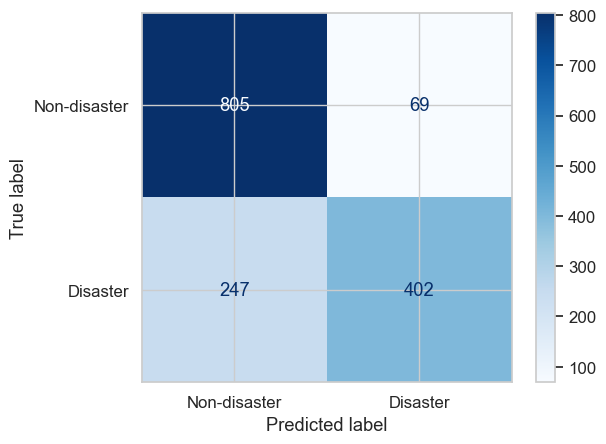

In [100]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-disaster", "Disaster"])
disp.plot(cmap="Blues")

# ROC Curve

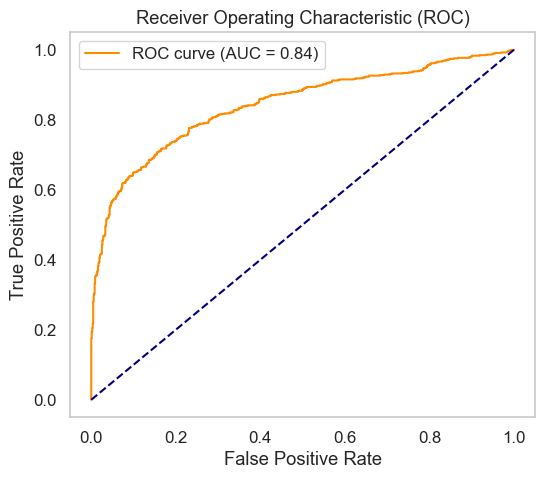

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.grid()
plt.show()


# Precision-Recall Curve

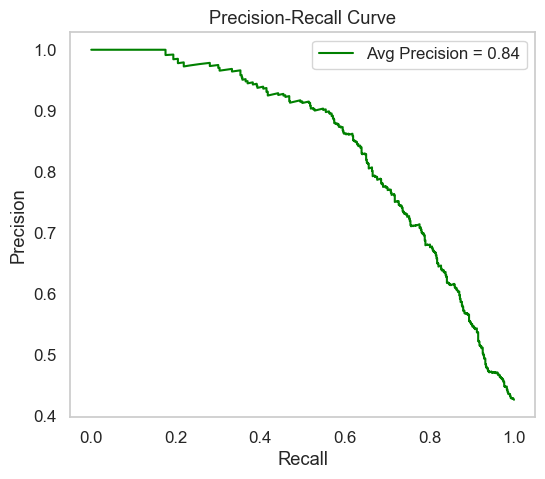

In [106]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', label=f"Avg Precision = {avg_prec:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


# Model Comparison Summary

In [109]:
from sklearn.metrics import f1_score, accuracy_score

models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'MLP Classifier': mlp
}

for name, model in models.items():
    pred = model.predict(X_test_final if name != 'Random Forest' else X_test_final.toarray())
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"{name:20} | Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")


Logistic Regression  | Accuracy: 0.8030 | F1-Score: 0.7541
Random Forest        | Accuracy: 0.7899 | F1-Score: 0.7153
MLP Classifier       | Accuracy: 0.7708 | F1-Score: 0.7263


# Model Validation

In [112]:
# Check for Overfitting
from sklearn.metrics import accuracy_score, f1_score

train_pred = best_rf.predict(X_train_final.toarray())
test_pred = best_rf.predict(X_test_final.toarray())

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

Train Accuracy: 0.9864
Test Accuracy : 0.7925


In [114]:
sample_tweets = [
    "Huge earthquake just hit Mexico!",
    "I'm burning my pizza. What a disaster!",
    "Wildfire spreading in California.",
    "Feeling cold. Might stay in bed."
]

# Clean tweets inline (if clean_text isn't available)
basic_clean = lambda s: re.sub(
    r'[^a-z\s]', ' ',
    re.sub(r'https?://\S+|www\.\S+|@\w+|#', ' ', s.lower())
).strip()

sample_cleaned = [basic_clean(t) for t in sample_tweets]
tfidf_input = tfidf.transform(sample_cleaned)

#  Define and enforce correct feature order
feature_cols = ['char_count', 'word_count', 'hashtag_count', 'mention_count',
                'neg', 'neu', 'pos', 'compound']

# Create metadata in exact order
sample_meta = pd.DataFrame({
    'char_count': [len(t) for t in sample_tweets],
    'word_count': [len(t.split()) for t in sample_tweets],
    'hashtag_count': [len(re.findall(r"#\w+", t)) for t in sample_tweets],
    'mention_count': [len(re.findall(r"@\w+", t)) for t in sample_tweets],
    'neg': [0.1]*4,
    'neu': [0.8]*4,
    'pos': [0.1]*4,
    'compound': [0.0]*4
})[feature_cols]  # enforce order

# Scale numeric features using trained scaler
scaled_meta = scaler.transform(sample_meta[feature_cols])

# Combine with TF-IDF
from scipy.sparse import hstack
final_input = hstack((tfidf_input, scaled_meta))

# Predict
preds = best_rf.predict(final_input)
for text, label in zip(sample_tweets, preds):
    print(f"[{'Disaster' if label else 'Non-Disaster'}] ➜ {text}")

[Disaster] ➜ Huge earthquake just hit Mexico!
[Non-Disaster] ➜ I'm burning my pizza. What a disaster!
[Disaster] ➜ Wildfire spreading in California.
[Non-Disaster] ➜ Feeling cold. Might stay in bed.
